In [2]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import warnings
warnings.filterwarnings('ignore')

2025-10-26 13:31:19.874608: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-26 13:31:20.211546: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-26 13:31:20.211642: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-26 13:31:20.268451: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-26 13:31:20.389383: I tensorflow/core/platform/cpu_feature_guar

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060 Ti, compute capability 8.9


2025-10-26 13:31:22.176652: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-26 13:31:22.377427: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-26 13:31:22.377480: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-26 13:31:22.377778: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [22]:
import platform
import psutil

print("=" * 50)
print("MACHINE SPECIFICATIONS")
print("=" * 50)
print(f"OS: {platform.system()} {platform.release()}")
print(f"Processor: {platform.processor()}")
print(f"RAM: {round(psutil.virtual_memory().total / (1024**3), 2)} GB")
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPUs Available: {tf.config.list_physical_devices('GPU')}")
print("=" * 50)

MACHINE SPECIFICATIONS
OS: Linux 6.6.87.2-microsoft-standard-WSL2
Processor: x86_64
RAM: 11.68 GB
TensorFlow Version: 2.15.0
GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [23]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [24]:
class MetricsLogger(keras.callbacks.Callback):
    """Custom callback to log training metrics per epoch."""
    def __init__(self):
        super().__init__()
        self.history_log = []
    
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.history_log.append(logs)
        print(f"Epoch {epoch+1}: {logs}")

def plot_history(history, metric='accuracy'):
    """Plot training and validation metrics."""
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[metric], label=f'Train {metric.capitalize()}')
    plt.plot(history.history[f'val_{metric}'], label=f'Val {metric.capitalize()}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.title(f'Training and Validation {metric.capitalize()}')
    plt.legend()
    plt.grid()
    plt.show()

In [7]:
# Set Kaggle API credentials path
os.environ['KAGGLE_CONFIG_DIR'] = str(Path.home() / '.kaggle')

# Download Indoor Plant Disease Dataset (23 classes)
# DATASET_NAME = 'pappu54/indoor-plant-disease-dataset-23-classes'
# !kaggle datasets download -d {DATASET_NAME} --unzip

# Set data directories (adjust based on extracted structure)
BASE_DIR = Path('dataset_flat_structure')
TRAIN_DIR = BASE_DIR / 'train'
VAL_DIR = BASE_DIR / 'validation'
TEST_DIR = BASE_DIR / 'test'

print(f"✅ Dataset downloaded to: {BASE_DIR}")

✅ Dataset downloaded to: dataset_flat_structure


In [26]:
# Count samples per class
def count_samples(directory):
    classes = [d.name for d in directory.iterdir() if d.is_dir()]
    counts = {cls: len(list((directory/cls).glob('*'))) for cls in classes}
    return counts

train_counts = count_samples(TRAIN_DIR)
val_counts = count_samples(VAL_DIR)
test_counts = count_samples(TEST_DIR)

# Create DataFrame
df_train = pd.DataFrame(list(train_counts.items()), columns=['Class', 'Train'])
df_val = pd.DataFrame(list(val_counts.items()), columns=['Class', 'Valid'])
df_test = pd.DataFrame(list(test_counts.items()), columns=['Class', 'Test'])
df = df_train.merge(df_val, on='Class').merge(df_test, on='Class')
df = df.sort_values('Train', ascending=False)

print("=" * 60)
print("DATASET STATISTICS")
print("=" * 60)
print(df)
print(f"\nTotal Training Samples: {df['Train'].sum()}")
print(f"Total Validation Samples: {df['Valid'].sum()}")
print(f"Total Test Samples: {df['Test'].sum()}")

DATASET STATISTICS
                                         Class  Train  Valid  Test
11                                Rose_Healthy   3871   1106   553
0                              Rose_Black_Spot   2100    600   300
20             Money Plant_Money_Plant_Healthy   1932    552   276
21                             Turmeric_Blotch   1333    381   190
4                             Turmeric_Healthy   1264    361   181
7                              Hibiscus_Scorch    840    240   120
9                             Hibiscus_Healthy    840    240   120
3                              Hibiscus_Blight    840    240   120
15                           Hibiscus_Necrosis    840    240   120
8                            Rose_Downy_Mildew    771    221   110
2                                    Rose_Rust    700    200   100
10                           Rose_Mosaic_Virus    700    200   100
18                         Rose_Powdery_Mildew    700    200   100
6                           Turmeric_Leaf_S

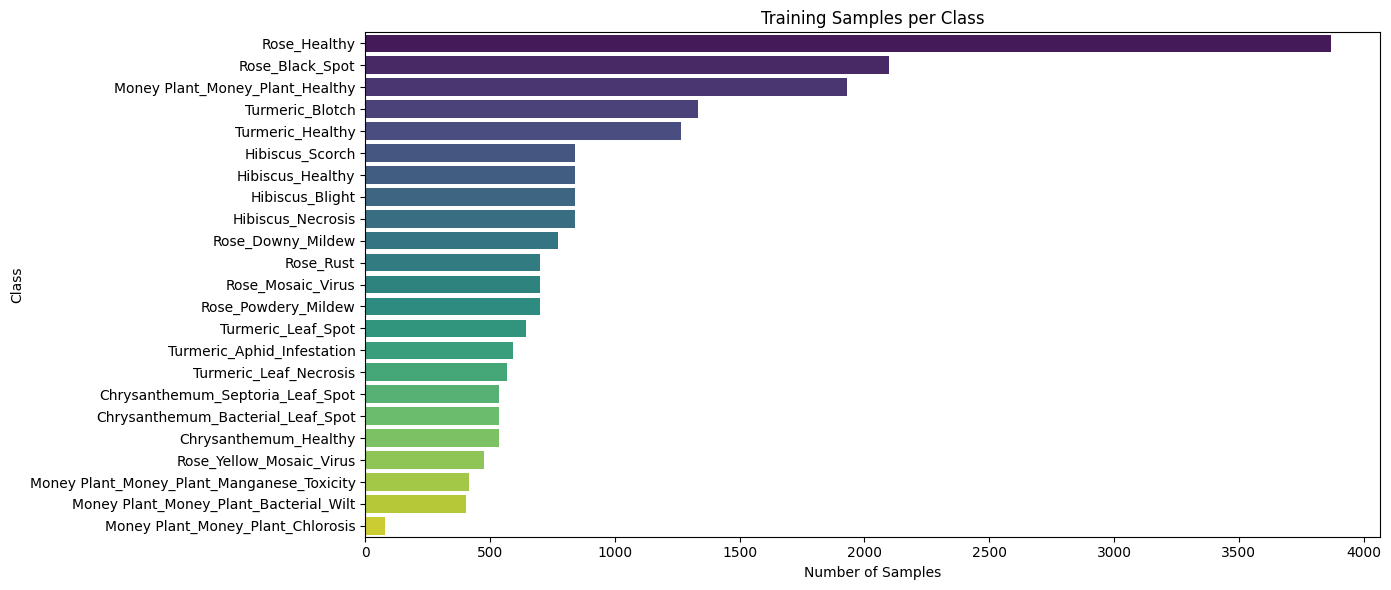

Imbalance Ratio (max/min): 47.79


In [27]:
plt.figure(figsize=(14, 6))
sns.barplot(data=df, x='Train', y='Class', palette='viridis')
plt.title('Training Samples per Class')
plt.xlabel('Number of Samples')
plt.ylabel('Class')
plt.tight_layout()
plt.show()

# Imbalance check
max_samples = df['Train'].max()
min_samples = df['Train'].min()
print(f"Imbalance Ratio (max/min): {max_samples / min_samples:.2f}")

In [8]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

# Load datasets using tf.data (much faster)
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    label_mode='categorical'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    label_mode='categorical'
)

# ✅ Store class names BEFORE transformation
class_names = train_ds.class_names
NUM_CLASSES = len(class_names)

# Data augmentation layer (GPU-accelerated)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
])

# Apply augmentation + rescaling
def prepare_train(ds):
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda x, y: (x / 255.0, y), num_parallel_calls=AUTOTUNE)
    return ds.prefetch(buffer_size=AUTOTUNE) 

def prepare_val_test(ds):
    ds = ds.map(lambda x, y: (x / 255.0, y), num_parallel_calls=AUTOTUNE)
    return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare_train(train_ds)
val_ds = prepare_val_test(val_ds)
test_ds = prepare_val_test(test_ds)

print(f"✅ Optimized data pipeline created.")
print(f"Classes: {NUM_CLASSES}")
print(f"Class names: {class_names}")

Found 21523 files belonging to 23 classes.
Found 6149 files belonging to 23 classes.
Found 3076 files belonging to 23 classes.
✅ Optimized data pipeline created.
Classes: 23
Class names: ['Chrysanthemum_Bacterial_Leaf_Spot', 'Chrysanthemum_Healthy', 'Chrysanthemum_Septoria_Leaf_Spot', 'Hibiscus_Blight', 'Hibiscus_Healthy', 'Hibiscus_Necrosis', 'Hibiscus_Scorch', 'Money Plant_Money_Plant_Bacterial_Wilt', 'Money Plant_Money_Plant_Chlorosis', 'Money Plant_Money_Plant_Healthy', 'Money Plant_Money_Plant_Manganese_Toxicity', 'Rose_Black_Spot', 'Rose_Downy_Mildew', 'Rose_Healthy', 'Rose_Mosaic_Virus', 'Rose_Powdery_Mildew', 'Rose_Rust', 'Rose_Yellow_Mosaic_Virus', 'Turmeric_Aphid_Infestation', 'Turmeric_Blotch', 'Turmeric_Healthy', 'Turmeric_Leaf_Necrosis', 'Turmeric_Leaf_Spot']


In [29]:
from collections import Counter

# Count samples per class from directory
train_counts = {}
for class_name in class_names:
    class_dir = TRAIN_DIR / class_name
    train_counts[class_name] = len(list(class_dir.glob('*')))

# Create label array
train_labels = []
for idx, class_name in enumerate(class_names):
    train_labels.extend([idx] * train_counts[class_name])

train_labels = np.array(train_labels)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(enumerate(class_weights))

print("Class Weights (for handling imbalance):")
for cls_idx, weight in class_weight_dict.items():
    print(f"Class {cls_idx} ({class_names[cls_idx]}): {weight:.3f}")

Class Weights (for handling imbalance):
Class 0 (Chrysanthemum_Bacterial_Leaf_Spot): 1.743
Class 1 (Chrysanthemum_Healthy): 1.743
Class 2 (Chrysanthemum_Septoria_Leaf_Spot): 1.743
Class 3 (Hibiscus_Blight): 1.114
Class 4 (Hibiscus_Healthy): 1.114
Class 5 (Hibiscus_Necrosis): 1.114
Class 6 (Hibiscus_Scorch): 1.114
Class 7 (Money Plant_Money_Plant_Bacterial_Wilt): 2.322
Class 8 (Money Plant_Money_Plant_Chlorosis): 11.553
Class 9 (Money Plant_Money_Plant_Healthy): 0.484
Class 10 (Money Plant_Money_Plant_Manganese_Toxicity): 2.244
Class 11 (Rose_Black_Spot): 0.446
Class 12 (Rose_Downy_Mildew): 1.214
Class 13 (Rose_Healthy): 0.242
Class 14 (Rose_Mosaic_Virus): 1.337
Class 15 (Rose_Powdery_Mildew): 1.337
Class 16 (Rose_Rust): 1.337
Class 17 (Rose_Yellow_Mosaic_Virus): 1.966
Class 18 (Turmeric_Aphid_Infestation): 1.578
Class 19 (Turmeric_Blotch): 0.702
Class 20 (Turmeric_Healthy): 0.740
Class 21 (Turmeric_Leaf_Necrosis): 1.648
Class 22 (Turmeric_Leaf_Spot): 1.455


In [30]:
def build_model(num_classes, freeze_base=True):
    base_model = MobileNetV3Large(
        input_shape=IMG_SIZE + (3,),
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )
    base_model.trainable = not freeze_base
    
    inputs = keras.Input(shape=IMG_SIZE + (3,))
    x = base_model(inputs, training=False)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs, name='MobileNetV3Large_PlantDisease')
    return model, base_model

model, base_model = build_model(NUM_CLASSES, freeze_base=True)
model.summary()

Model: "MobileNetV3Large_PlantDisease"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Function  (None, 960)               2996352   
 al)                                                             
                                                                 
 batch_normalization_1 (Bat  (None, 960)               3840      
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 960)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               492032    
                                                                 
 batch_normalization_2 (Bat  (None, 5

In [ ]:
INITIAL_LR_P1 = 1e-3
EPOCHS_P1 = 40

UFREEZ_LAYERS = -80
INITIAL_LR_P2 = 5e-3
EPOCHS_P2 = 80

In [ ]:
lr_schedule_phase1 = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=INITIAL_LR_P1,
    decay_steps=len(train_ds) * EPOCHS_P1
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule_phase1),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=3, name='top3_acc')]
)

callbacks_phase1 = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.5, min_lr=1e-7, verbose=1),
    keras.callbacks.ModelCheckpoint('mobilenetv3_phase1.keras', save_best_only=True, verbose=1)
]

history_phase1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_P1,
    class_weight=class_weight_dict,
    callbacks=callbacks_phase1,
    verbose=1
)


# Save phase 1 history
# Save phase 1 history (convert numpy float32 to Python float)
with open('phase1_history.json', 'w') as f:
    json.dump({k: [float(v) for v in vals] for k, vals in history_phase1.history.items()}, f, indent=2)

Epoch 1/40
673/673 [==============================] - ETA: 0s - loss: 3.0757 - accuracy: 0.2558 - top3_acc: 0.5584
Epoch 1: val_loss improved from inf to 2.62589, saving model to mobilenetv3_phase1.keras
673/673 [==============================] - 41s 54ms/step - loss: 3.0757 - accuracy: 0.2558 - top3_acc: 0.5584 - val_loss: 2.6259 - val_accuracy: 0.3667 - val_top3_acc: 0.7245 - lr: 9.9846e-04
Epoch 2/40
672/673 [============================>.] - ETA: 0s - loss: 2.6223 - accuracy: 0.3247 - top3_acc: 0.6712
Epoch 2: val_loss improved from 2.62589 to 2.34884, saving model to mobilenetv3_phase1.keras
673/673 [==============================] - 37s 54ms/step - loss: 2.6215 - accuracy: 0.3248 - top3_acc: 0.6713 - val_loss: 2.3488 - val_accuracy: 0.4420 - val_top3_acc: 0.7980 - lr: 9.9385e-04
Epoch 3/40
673/673 [==============================] - ETA: 0s - loss: 2.4330 - accuracy: 0.3494 - top3_acc: 0.7045
Epoch 3: val_loss improved from 2.34884 to 2.26782, saving model to mobilenetv3_phase1.ke

In [ ]:
# Unfreeze last 80 layers
base_model.trainable = True
for layer in base_model.layers[:UFREEZ_LAYERS]:
    layer.trainable = False

lr_schedule_phase2 = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=INITIAL_LR_P2,
    decay_steps=len(train_ds) * EPOCHS_P2
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule_phase2),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=3, name='top3_acc')]
)

callbacks_phase2 = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=6, factor=0.5, min_lr=1e-8, verbose=1),
    keras.callbacks.ModelCheckpoint('mobilenetv3_phase2.keras', save_best_only=True, verbose=1)
]

history_phase2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_P2,
    class_weight=class_weight_dict,
    callbacks=callbacks_phase2,
    verbose=1
)


# Save final model in multiple formats
model.save('mobilenetv3_final.keras')
model.save('mobilenetv3_final.h5')
model.save_weights('mobilenetv3_final_weights.h5')

# Save phase 2 history
with open('phase2_history.json', 'w') as f:
    json.dump({k: [float(v) for v in vals] for k, vals in history_phase2.history.items()}, f, indent=2)

print("✅ Models saved: .keras, .h5, weights.h5")

Epoch 1/80
673/673 [==============================] - ETA: 0s - loss: 1.9218 - accuracy: 0.4390 - top3_acc: 0.7907
Epoch 1: val_loss improved from inf to 4.97334, saving model to mobilenetv3_phase2.keras
673/673 [==============================] - 46s 61ms/step - loss: 1.9218 - accuracy: 0.4390 - top3_acc: 0.7907 - val_loss: 4.9733 - val_accuracy: 0.1153 - val_top3_acc: 0.3563 - lr: 4.9981e-05
Epoch 2/80
673/673 [==============================] - ETA: 0s - loss: 1.7901 - accuracy: 0.4867 - top3_acc: 0.8383
Epoch 2: val_loss improved from 4.97334 to 4.01676, saving model to mobilenetv3_phase2.keras
673/673 [==============================] - 38s 56ms/step - loss: 1.7901 - accuracy: 0.4867 - top3_acc: 0.8383 - val_loss: 4.0168 - val_accuracy: 0.1776 - val_top3_acc: 0.3739 - lr: 4.9923e-05
Epoch 3/80
672/673 [============================>.] - ETA: 0s - loss: 1.7252 - accuracy: 0.5139 - top3_acc: 0.8511
Epoch 3: val_loss did not improve from 4.01676
673/673 [==============================] -

In [4]:
# Reload model
model = keras.models.load_model('mobilenetv3_final.keras')

# Reload history
with open('phase1_history.json') as f:
    history_phase1_dict = json.load(f)
with open('phase2_history.json') as f:
    history_phase2_dict = json.load(f)

print("✅ Model and history reloaded.")

2025-10-26 13:32:07.089955: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-26 13:32:07.090050: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-26 13:32:07.090071: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-26 13:32:07.270098: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-26 13:32:07.270159: I external/local_xla/xla/stream_executor

✅ Model and history reloaded.


In [9]:
test_loss, test_acc, test_top3 = model.evaluate(test_ds, verbose=1)
print(f"\n{'='*50}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Top-3 Accuracy: {test_top3:.4f}")
print(f"{'='*50}")

2025-10-26 13:33:28.061399: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


97/97 [==============================] - 5s 22ms/step - loss: 3.9289 - accuracy: 0.2259 - top3_acc: 0.4298

Test Loss: 3.9289
Test Accuracy: 0.2259
Test Top-3 Accuracy: 0.4298


In [35]:
# Get predictions
y_pred = model.predict(test_ds, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Extract true labels from test dataset
y_true = []
for _, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot to class indices
y_true = np.array(y_true)

# Get class names (stored earlier)
report = classification_report(y_true, y_pred_classes, target_names=class_names, digits=3)

print("=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
print(report)

97/97 [==============================] - 2s 15ms/step
CLASSIFICATION REPORT
                                            precision    recall  f1-score   support

         Chrysanthemum_Bacterial_Leaf_Spot      0.000     0.000     0.000        77
                     Chrysanthemum_Healthy      1.000     0.039     0.075        77
          Chrysanthemum_Septoria_Leaf_Spot      0.000     0.000     0.000        77
                           Hibiscus_Blight      0.000     0.000     0.000       120
                          Hibiscus_Healthy      0.778     0.058     0.109       120
                         Hibiscus_Necrosis      0.000     0.000     0.000       120
                           Hibiscus_Scorch      0.459     0.142     0.217       120
    Money Plant_Money_Plant_Bacterial_Wilt      0.000     0.000     0.000        58
         Money Plant_Money_Plant_Chlorosis      0.036     0.091     0.051        11
           Money Plant_Money_Plant_Healthy      0.134     0.377     0.197       276

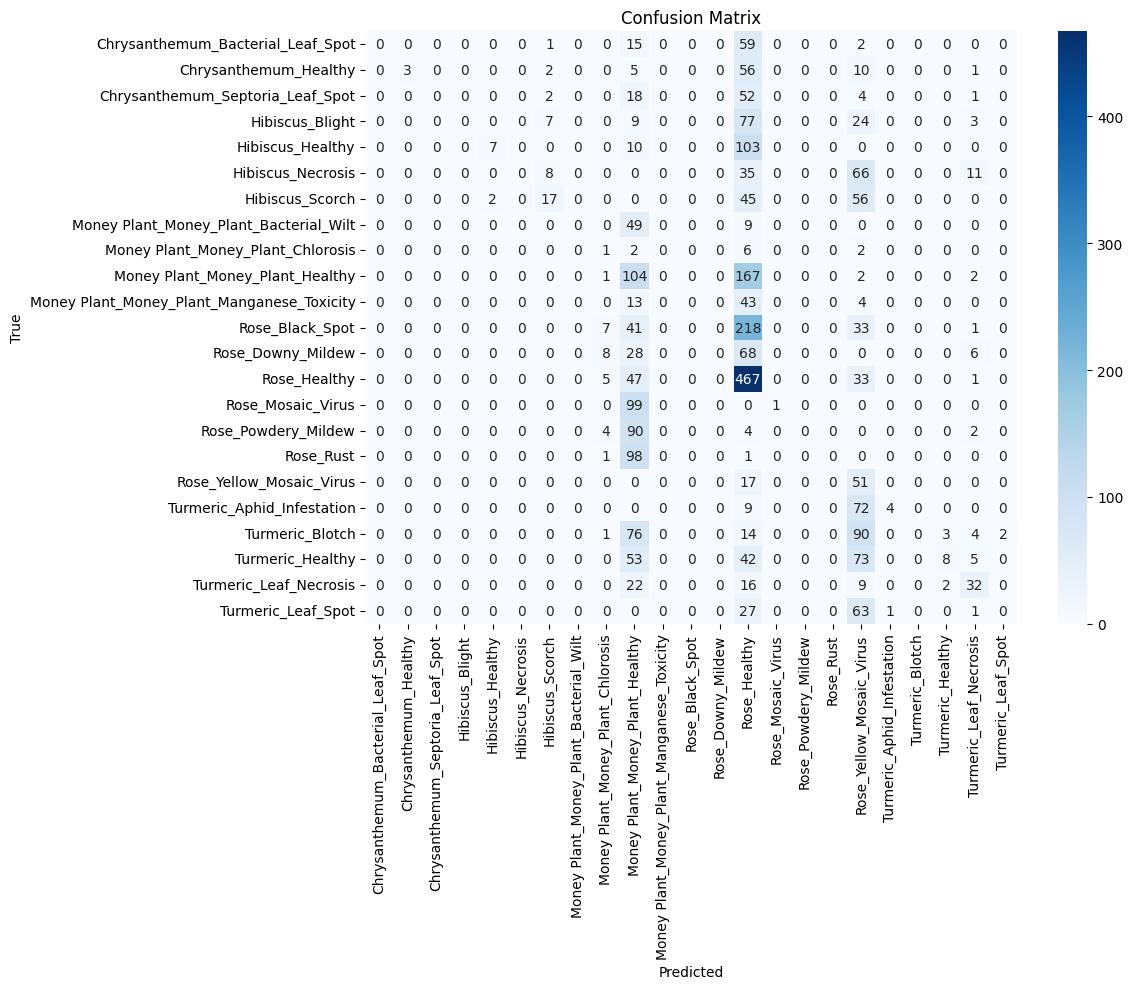

In [36]:
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

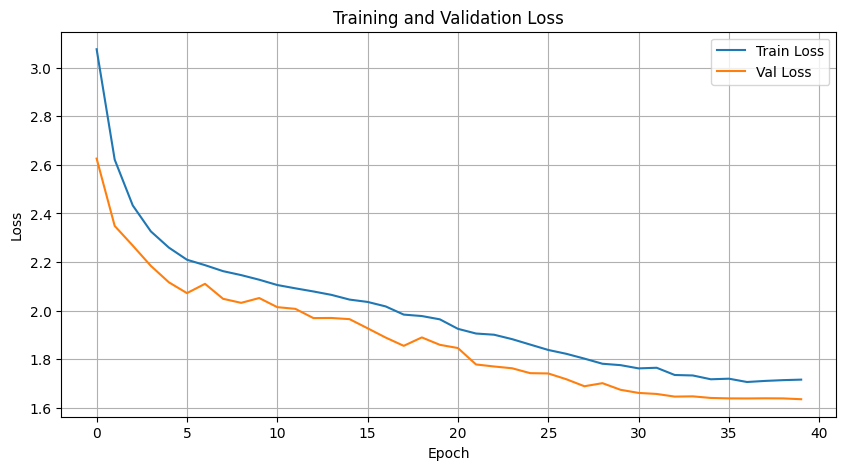

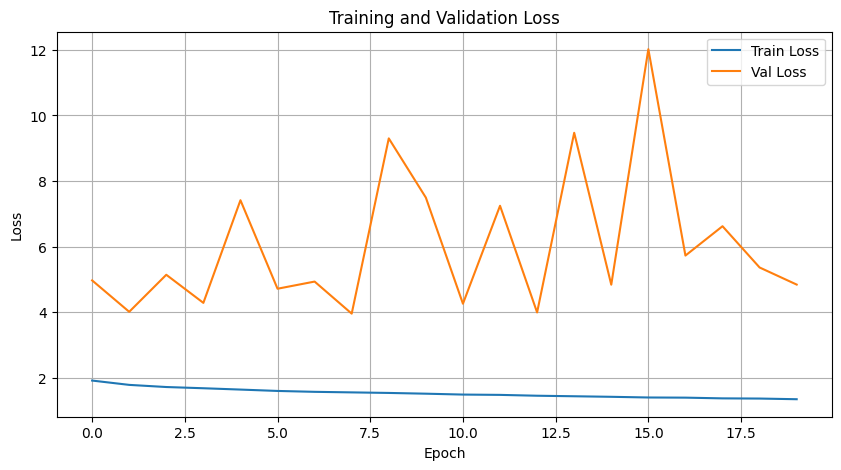

In [37]:
plot_history(history_phase1, 'loss')
plot_history(history_phase2, 'loss')

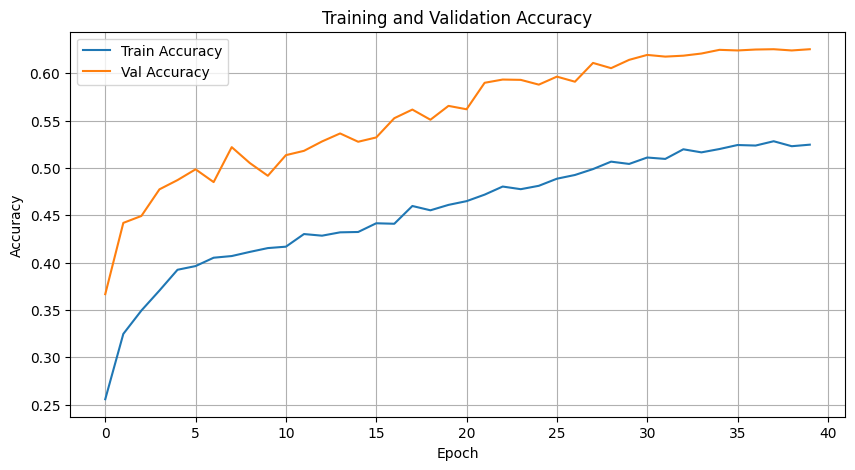

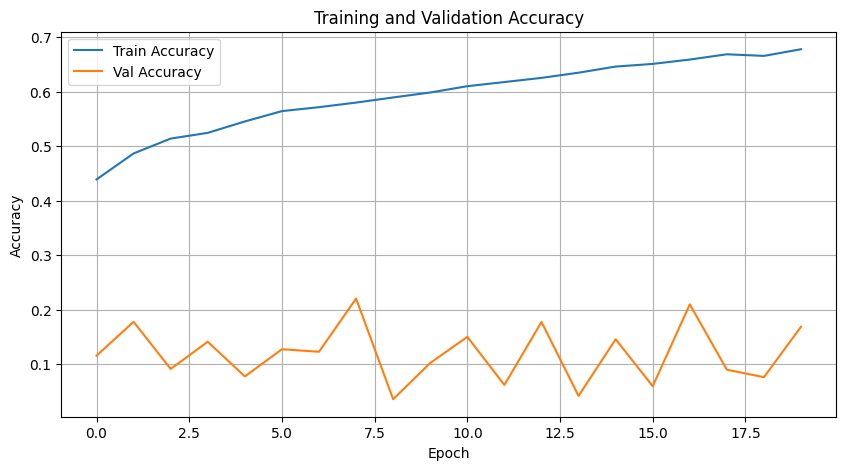

In [38]:
plot_history(history_phase1, 'accuracy')
plot_history(history_phase2, 'accuracy')

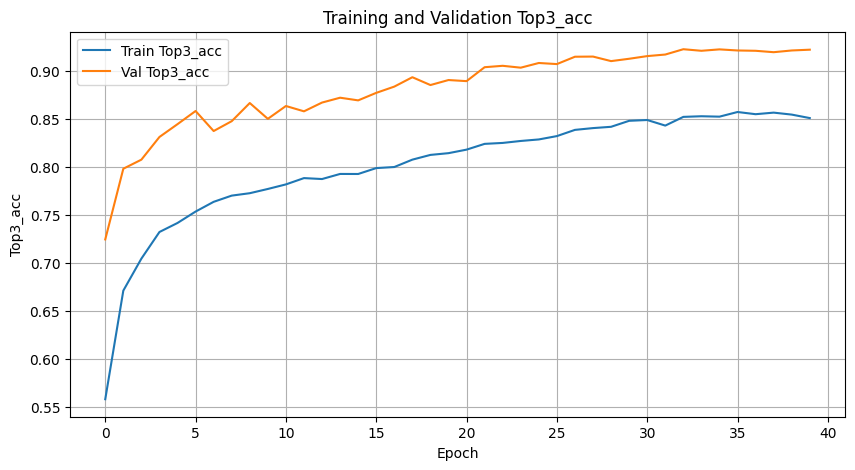

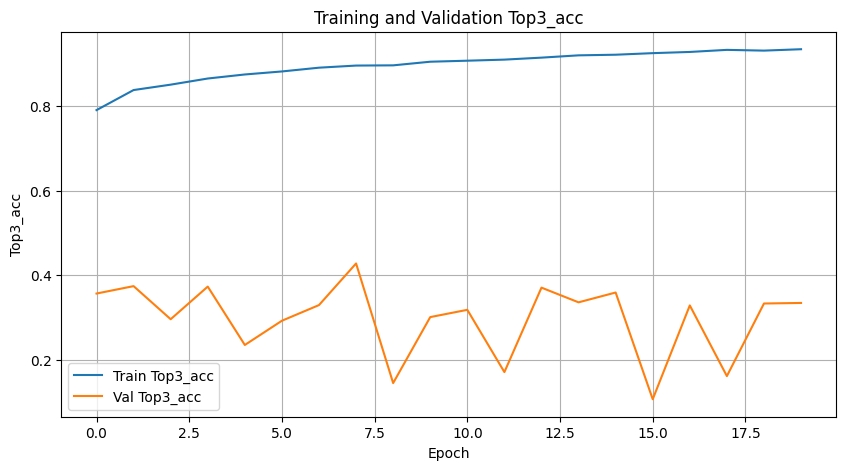

In [39]:
plot_history(history_phase1, 'top3_acc')
plot_history(history_phase2, 'top3_acc')